In [ ]:
# Imports

import pandas as pd
import numpy as np
import torch
from torch import nn

# Working with Datasets

from torch.utils.data import DataLoader
from torch.utils.data import Dataset

# XZ
import os
import pandas as pd
from torchvision.io import read_image
from tqdm import tqdm

# Datasets

from torchvision.datasets import FashionMNIST
from torchvision.transforms import Resize

# Optimizer

from torch.optim import Adam

# Visualisation

import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
import torchvision.transforms as T
from torchvision.utils import draw_bounding_boxes
from IPython.display import clear_output

In [ ]:
to_tensor = T.ToTensor()
to_pil = T.ToPILImage()
to_resize = T.Resize([100,100])

transformation = T.Compose([to_resize,to_tensor])

dataset_train = FashionMNIST("https://github.com/zalandoresearch/fashion-mnist",train = True, download = True,
                            transform = transformation)
dataset_test = FashionMNIST("https://github.com/zalandoresearch/fashion-mnist",train = False, download = True,
                           transform = transformation)

In [ ]:
idx2text = {0: "T-shirt/top",
 1: "Trouser",
 2: "Pullover",
 3: "Dress",
 4: "Coat",
 5: "Sandal",
 6: "Shirt",
 7: "Sneaker",
 8: "Bag",
 9: "Ankle boot"}

# Создадим DataLoaders

In [ ]:
train_dataloader = DataLoader(dataset_train,batch_size = 8,shuffle = True, num_workers = 4)
test_dataloader = DataLoader(dataset_test,batch_size = 8,shuffle = True, num_workers = 4)

In [ ]:
# Lets check into pic size
# x_s, y_s will be used later in code
x_s, y_s = next(iter(train_dataloader))


# Опредялем Device

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

# Обучаем модель из Encoder и Decoder

In [ ]:
class Block(nn.Module):
    def __init__(self, in_channels: int, out_channels: int, kernel_size: int, stride: int = 1, upsample: bool = False):
        
        super().__init__()
        self.upsample = upsample

        self.conv = nn.Conv2d(
            in_channels=in_channels,
            out_channels=out_channels,
            kernel_size=kernel_size,
            stride=stride,
            padding=1,
            bias=False
        )
        
        self.norm = nn.BatchNorm2d(out_channels)
        self.act = nn.LeakyReLU(0.2)

    def forward(self, x):
        
        if self.upsample:
            x = nn.functional.interpolate(x, scale_factor=2, mode='bilinear', align_corners=False, recompute_scale_factor=False)\
        
        #print(f"Img_size = {x.size()}")

        return self.act(self.norm(self.conv(x)))


In [121]:
import math
class AutoEncoder(nn.Module):
    def __init__(self, in_channels: int, base_block: nn.Module = Block, base_size: int = 32, num_blocks: int = 4):
        
        super().__init__()
        self.base_size = base_size
        
        # encoder creation

        encoder_blocks = []

        for i in range(num_blocks):
            encoder_blocks.append(
                base_block(
                    in_channels=base_size if i else in_channels, # in_channels если это самый первый блок
                    out_channels=base_size,
                    kernel_size=3,
                    stride=2
                )
            )

        encoder_blocks.append(
            base_block(
                in_channels=base_size,
                out_channels=base_size,
                kernel_size=3
            ).conv
        )
        
        self.encoder = nn.Sequential(*encoder_blocks)  # N -> N // (2 ** num_blocks)

        # decoder creation

        decoder_blocks = []

        for i in range(num_blocks):
            decoder_blocks.append(
                base_block(
                    in_channels=base_size,
                    out_channels=base_size,
                    kernel_size=3,
                    upsample=True
                )
            )

        decoder_blocks.append(
            base_block(
                in_channels=base_size,
                out_channels=in_channels,
                kernel_size=3
            ).conv
        )
        
        decoder_blocks.append(nn.Sigmoid()) # конкретно для MNIST, но можно 

        self.decoder = nn.Sequential(*decoder_blocks)  # N // (2 ** num_blocks) -> N

        self.flatten = nn.Flatten()

    def forward(self, x):
        # x.shape = [bs, in_channels, N, N]
        x = self.encoder(x)
        # x.shape = [bs, base_size, N // (2 ** num_blocks), N // (2 ** num_blocks)]
        x = self.decoder(x)
        # x.shape = [bs, in_channels, N, N]
        
        t_resize = T.Resize([100,100], antialias=True)
        
        x = t_resize(x)

        return x

    @torch.inference_mode()
    def encode(self, x):
        # x.shape = [bs, in_channels, N, N]
        return self.encoder(x)
        #return self.flatten(self.encoder(x)) # output.shape = [bs, base_size * N ** 2 / (2 ** num_blocks) ** 2]

    @torch.inference_mode()
    def decode(self, x):
        # x.shape = [bs, base_size * N ** 2 / (2 ** num_blocks) ** 2]
        latent_size = int(math.sqrt(x.shape[1] // self.base_size))

        return self.decoder(x.view(-1, self.base_size, latent_size, latent_size))  # output.shape = [bs, in_channels, N, N]

In [122]:
def train(model):
    model.train()

    train_loss = 0

    for x, _ in tqdm(train_dataloader, desc='Train'):
        x = x.to(device)

        optimizer.zero_grad()

        output = model(x)

        loss = loss_fn(output, x)

        train_loss += loss.item()

        loss.backward()

        optimizer.step()

    train_loss /= len(train_dataloader)

    return train_loss

In [123]:
model = AutoEncoder(in_channels= 1, base_size = 100, num_blocks=4)
model.to(device)

optimizer = Adam(params=model.parameters(), lr = 1e-3)
loss_fn = nn.MSELoss()

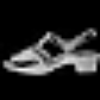

In [124]:
to_resize(to_pil(x_s[0]))

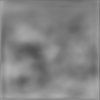

In [125]:
x_s = x_s.to(device)
to_resize(to_pil(model.forward(x_s)[0]))

In [126]:
model.forward(x_s).size()

torch.Size([8, 1, 100, 100])

In [135]:
loss_list = []
for epoch in range(5):
    loss = train(model)
    loss_list.append(loss)

Train: 100%|██████████| 7500/7500 [03:48<00:00, 32.87it/s]


Text(0.5, 0, 'N Epoch')

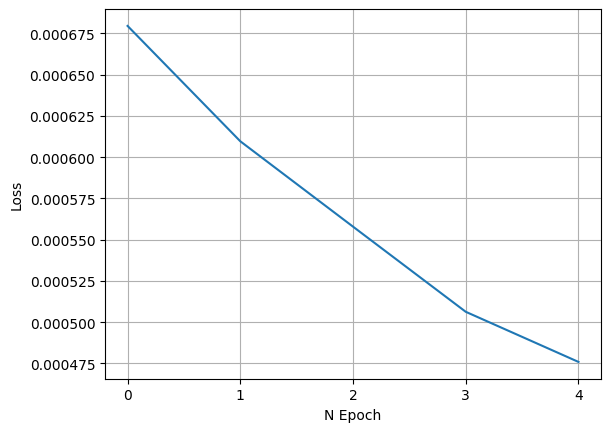

In [137]:
plt.plot(loss_list)
plt.ylabel("Loss")
plt.xticks(ticks = range(5))
plt.grid(True, axis = "both")
plt.xlabel("N Epoch")

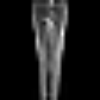

In [138]:
to_resize(to_pil(x_s[0]))

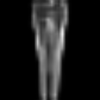

In [139]:
x_s = x_s.to(device)
to_resize(to_pil(model.forward(x_s)[0]))

In [182]:
def get_plot(batch_output,batch_real):
    for i_pic,r_pic in zip(batch_output,batch_real):
        #print(i_pic.size(),r_pic.size())
        
        plt.subplot(1,2,1)
        i_pic = i_pic.squeeze(0)
        plt.imshow(to_pil(i_pic))
        plt.title("Encoded img")
        
        plt.subplot(1,2,2)
        r_pic = r_pic.squeeze(0)
        plt.imshow(to_pil(r_pic))
        plt.title("Real img")
        
        plt.show() 
        plt.tight_layout() # Adjust the spacing between subplots

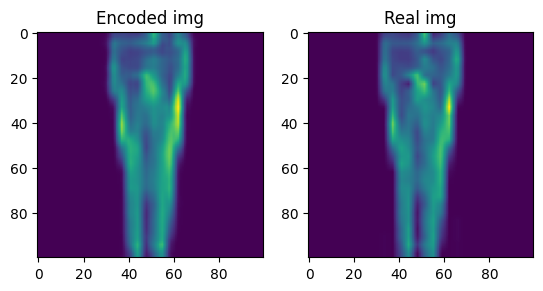

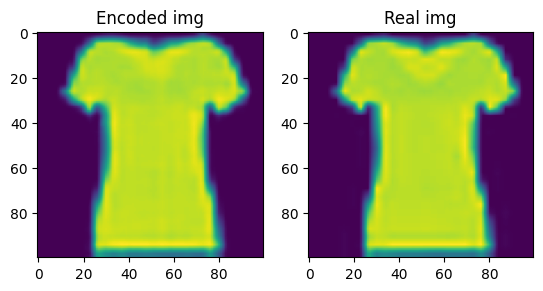

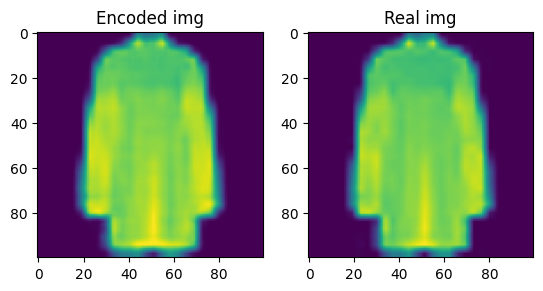

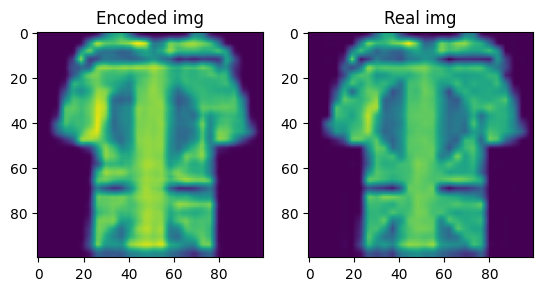

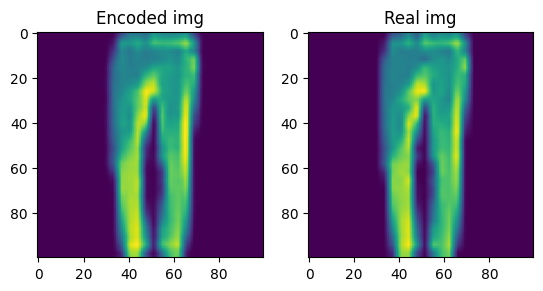

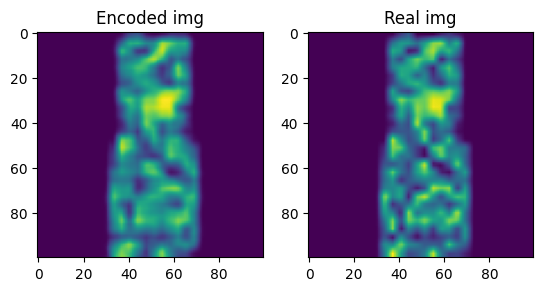

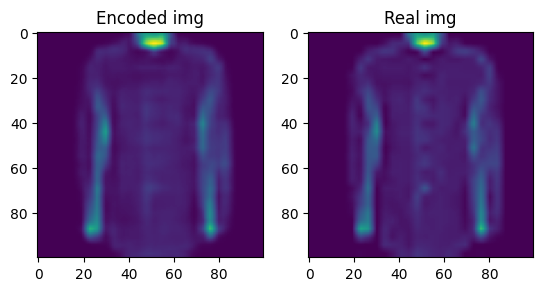

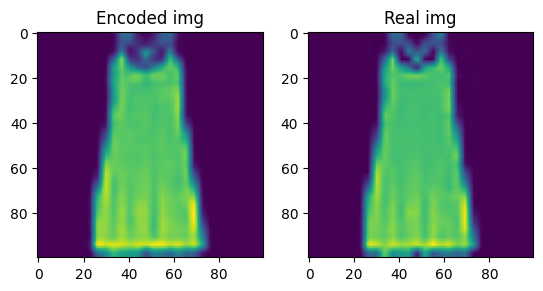

<Figure size 640x480 with 0 Axes>

In [183]:
get_plot(model.forward(x_s),x_s)